In [36]:
import sys; sys.path.insert(0, '..')

In [37]:
import pandas as pd
from tqdm import notebook
from utils.regex_fx import remove_mention, remove_non_ascii, remove_emojis, remove_urls, remove_nonalpha, remove_extra_spaces, remove_special_words, remove_rt, remove_single_char, remove_numbers
import spacy
import re
import numpy as np
nlp = spacy.load("en_core_web_sm")
from gensim.models import LdaMulticore, Phrases
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from collections import Counter

import itertools
from fuzzywuzzy import fuzz

In [38]:
def cleanup(text):
    res = remove_mention(text)
    res = remove_non_ascii(res)
    res = res.lower()
    res = remove_urls(res)
    res = remove_rt(res)
    res = remove_single_char(res)
    res = remove_numbers(res)
    res = remove_emojis(res)
    res = remove_nonalpha(res)
    res = remove_extra_spaces(res)
    res = remove_special_words(res)
    return res

In [158]:
fake = pd.read_csv('fake.csv')
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32654 entries, 0 to 32653
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  32654 non-null  int64  
 1   created_at  32654 non-null  object 
 2   text        32654 non-null  object 
 3   author_id   32653 non-null  float64
 4   id          32653 non-null  float64
 5   news_id     32653 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.5+ MB


In [164]:
real = pd.read_csv('real.csv')

In [105]:
fake = pd.read_csv('fake.csv')

In [165]:
real_cleaned = []
for item in real.text.to_list():
    real_cleaned.append(cleanup(item))
real.text = real_cleaned

In [159]:
fake_cleaned = []
for item in fake.text.to_list():
    fake_cleaned.append(cleanup(item))
fake.text = fake_cleaned

In [161]:
processedRealStrings = []
matchers = []

for real in real_cleaned:
    if real:
        processedClean = fuzz._process_and_sort(real, True, True)
        processedRealStrings.append({"processed": processedClean, "string": real})

processedRealStrings.sort(key= lambda x: len(x["processed"]))

for idx, real in notebook.tqdm(enumerate(processedRealStrings)):
    length = len(real["processed"])
    matcher = fuzz.SequenceMatcher(None, real["processed"])
    for idx2 in range(idx + 1, len(processedRealStrings)):
        real2 = processedRealStrings[idx2]
        if 2 * length / (length + len(real2["processed"])) < 0.85: # upper bound
            break

        matcher.set_seq2(real2["processed"])

        if matcher.quick_ratio() >= 0.85: # should also try without quick_ratio() check
            # print(real["string"], real2["string"])
            processedRealStrings.remove(real2)

In [276]:
processedFakeStrings = []
matchers = []

for fake in fake_cleaned:
    if fake:
        processedClean = fuzz._process_and_sort(fake, True, True)
        processedFakeStrings.append({"processed": processedClean, "string": fake})

processedFakeStrings.sort(key= lambda x: len(x["processed"]))

for idx, fake in notebook.tqdm(enumerate(processedFakeStrings)):
    length = len(fake["processed"])
    matcher = fuzz.SequenceMatcher(None, fake["processed"])
    for idx2 in range(idx + 1, len(processedFakeStrings)):
        fake2 = processedFakeStrings[idx2]
        if 2 * length / (length + len(fake2["processed"])) < 0.85: # upper bound
            break

        matcher.set_seq2(fake2["processed"])

        if matcher.quick_ratio() >= 0.85: # should also try without quick_ratio() check
            processedFakeStrings.remove(fake2)

0it [00:00, ?it/s]

IndexError: list index out of range

In [283]:
import random

In [288]:
string_array = []
real_string_array = []
for item in processedFakeStrings:
    if len(item['string']) > 100:
        string_array.append(item['string'])
print(len(string_array))
# a lot less fake than real, pick this many random from the real:
for item in processedStrings:
    if len(item['string']) > 100:
        real_string_array.append(item['string'])
real_sample = random.sample(real_string_array, len(string_array))
string_array += real_sample

18472


In [291]:
np.save('over_100_non_duplicate', string_array)

In [82]:
np.save('real_over_100_non_duplicate', real_string_array)

In [43]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).quick_ratio()

In [9]:
i=0
counter=10
if i < counter:
    fake.reset_index(drop=True, inplace=True)
    for index, item in notebook.tqdm(fake.iterrows()):
        if index < len(fake)-1:
            if similar(fake.loc[index,'text'], fake.loc[index+1,'text']) > 0.90:
                fake.drop(index, inplace = True)
    real.reset_index(drop=True, inplace=True)
    for index, item in notebook.tqdm(real.iterrows()):
        if index < len(real)-1:
            if similar(real.loc[index,'text'], real.loc[index+1,'text']) > 0.90:
                real.drop(index, inplace = True)
    i+=1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [247]:
real = real.drop_duplicates(subset=['text'], keep='first')
real = real.sort_values('text')
real = real[real.text.notnull()]
real = real[real.text != ""]
real = real[real.text.str.len() > 100]
real_subset = real.groupby('news_id').apply(lambda x: x.sample(frac=0.147625))
real_subset

Unnamed: 0            id  \
news_id                                            
politifact10185 102534      107077  8.500873e+17   
                131461      137159  5.251237e+17   
                115906      120806  8.833904e+17   
                56659        59504  9.656164e+17   
                76908        80646  5.266610e+17   
...                            ...           ...   
politifact99    171476      179231  9.862678e+17   
                151019      157792  9.500483e+17   
                42059        44256  8.334005e+17   
                39484        41552  8.483562e+17   
                178249      186424  9.585297e+17   

                                                                                                                                                                                                                                                                                                     text  \
news_id                                                                                                                                                                                                                                                                                                     
politifact10185 102534                                                                                                                                                            mcspocky naral but as usual those guys are trying to blame democrats this is game republicans will lose in the long run   
                131461                                                                                                                                                                           politico opinion if democrats lose blame these guys via politicomag possible suit filed to remove booker   
                115906                                                                                                                                                     national democrat party hillary vision were not as bad as the other guys when they lose theyll blame progressives and russians   
                56659   foxandfriends democrats are the enemy not russia or trumpthese lying criminal bastards take out horrible lying adds against all republicanshire women to lie about having sex with trumpthats seems ok with fox now daysi think guys being told to be more liberaldont blame lose   
                76908                                                                                                                                                                        if democrats lose blame these guys its time for career politicians of both parties to go away retire get out   
...                                                                                                                                                                                                                                                                                                   ...   
politifact99    171476                                                                     theview michaelavenatti my issue with the interview was meghanmccain attacking stormy for taking advantage of her recent notoriety would meghan be on the view if her father wasnt john mccain highly doubt it   
                151019              senjohnmccain sad sad the interview with chuck todd and lindsey graham shows that one of the last hold outs of the putin take over the usa has been turned history will be written that the great puppet master took over the republican party putin republican party   
                42059                                                                                                                                                                      dictators get started by shutting down the press sen john mccain said in an interview with nbcs meet the press   
                39484               

In [238]:
fake = fake.drop_duplicates(subset=['text'], keep='first')
fake = fake.sort_values('text')
fake = fake[fake.text.notnull()]
fake = fake[fake.text != ""]
fake = fake[fake.text.str.len() > 100]
fake_subset = fake.groupby('news_id').apply(lambda x: x.sample(frac=1))
fake_subset

Unnamed: 0                created_at  \
news_id                                                       
politifact13496 23450       25669  2016-11-25T20:30:24.000Z   
                23484       25716  2016-11-25T20:26:16.000Z   
                14731       15992  2016-11-27T03:40:51.000Z   
politifact13515 16875       18413  2018-02-28T14:01:11.000Z   
                21308       23267  2018-02-27T23:54:28.000Z   
...                           ...                       ...   
politifact15631 14606       15862  2018-07-19T04:36:02.000Z   
                14610       15867  2018-07-18T22:33:36.000Z   
                14602       15858  2018-07-19T03:51:26.000Z   
                18163       19798  2018-07-20T16:03:49.000Z   
                14603       15859  2018-07-18T16:04:45.000Z   

                                                                                                                                                                                                                                                text  \
news_id                                                                                                                                                                                                                                                
politifact13496 23450                                                                                                               the cnn porn scare is how fake spreads last night twitter account by the name of tweeted out surprising image of   
                23484                                                                                                       the cnn porn scare is how fake spreads wnn2 last night twitter account by the name of solikearose tweeted out surprising   
                14731                                                                                                                        lol think before you react to anything on social media the cnn porn scare is how fake spreads the verge   
politifact13515 16875                                   no thanks will not be voting for this dishragtexas agriculture commissioner and top donald surrogate sid millers twitter account called democratic presidential nominee hillary clinton cunt   
                21308                                                                                          sid miller vulgar controversial candidate for trumps cabinet fox fav wonder why hes man hope texas voters defeat him we can do better   
...                                                                                                                                                                                                                                              ...   
politifact15631 14606                                                                                                       lisa page squeals dnc server was not hacked by russia via this person can take down the rest of the swamp in single jump   
                14610                                lisa page squeals dnc server was not hacked by russiajuly sean adltabatabailisa page former fbi lawyer under james comey and andrew mccabe has become the latest rat to depart the sinking ship   
                14602                    lisa page squeals dnc server was not hacked by russia via is anyone going to go to prison for politicizing the fbi covering up countless crimes committed by fbi personnel to protect hillary the democrats   
                18163  page says it was china not russia who hacked the dnchow about the truth it was the fbi who hacked the dnc if anyone didit could all be another hillary clinton lie to cover her tracks of the many felonies she has committed   
                14603                                                                                               lisa page squeals dnc server was not hacked by russia via lock them up now hang them all just saying wwg1wga wh

In [248]:
combined = fake_subset.append(real_subset)

In [249]:
text_list = combined.text
text_list = text_list.tolist()


In [292]:
text_list = string_array

In [293]:
processed_texts = [text for text in notebook.tqdm(nlp.pipe(text_list, 
                                                n_process=-1, # maximum number of threads
                                                disable=["ner", "parser"]),
                                                total=len(text_list))]

  0%|          | 0/36944 [00:00<?, ?it/s]

In [294]:
tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]

  0%|          | 0/36944 [00:00<?, ?it/s]

In [295]:
# rmv = ['nt', 's' ,'rt', 'm', 'barackobama', 'fox', 'see', 'donald', 've', 'year', 'foxnew', 'de', 'cnn', 'amp', 'news', 'obama', 'realdonaldtrump', 'go', 'new']
# rmv = ['nt', 's', ' ', 'm', 've', 'gt']
rmv = ['house', 'america', 'representative', 'wakeupamerica', 'wake', 'fox', 'foxnew', 'foxnews', 'amp', 'de', 'cnn', 'm', 've', 'nt', 's', ' ']
tokenized_texts = [[i for i in nested if i not in rmv ] for nested in tokenized_texts]

In [296]:
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

In [297]:
def process_tokenized(tokenized_texts):
    # tokenized_texts = make_n_grams(tokenized_texts)
    flatten = lambda t: [item for sublist in t for item in sublist]
    flattened = flatten(tokenized_texts)
    counts = Counter(flattened)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flattened, tokenized_texts

In [298]:
tokenized_obj = process_tokenized(tokenized_texts)
counts_combined, common_combined, flattened_combined, tokenized_texts_combined = tokenized_obj

In [299]:
common_combined[:100]

[('state', 3426),
 ('people', 3079),
 ('president', 3035),
 ('vote', 2501),
 ('like', 2480),
 ('say', 2262),
 ('interview', 2171),
 ('time', 2082),
 ('know', 2001),
 ('need', 1963),
 ('federal', 1862),
 ('go', 1810),
 ('republican', 1752),
 ('american', 1709),
 ('right', 1709),
 ('think', 1657),
 ('want', 1633),
 ('day', 1630),
 ('statement', 1579),
 ('good', 1553),
 ('senate', 1512),
 ('country', 1415),
 ('nation', 1399),
 ('speech', 1374),
 ('get', 1373),
 ('code', 1370),
 ('regulation', 1368),
 ('today', 1355),
 ('control', 1319),
 ('white', 1296),
 ('come', 1259),
 ('work', 1253),
 ('election', 1234),
 ('watch', 1212),
 ('look', 1193),
 ('great', 1166),
 ('video', 1151),
 ('congress', 1131),
 ('union', 1106),
 ('year', 1096),
 ('woman', 1095),
 ('national', 1080),
 ('lie', 1068),
 ('face', 1031),
 ('member', 1031),
 ('meet', 1030),
 ('week', 1029),
 ('let', 1027),
 ('party', 997),
 ('bill', 987),
 ('way', 986),
 ('world', 975),
 ('tell', 966),
 ('law', 946),
 ('run', 944),
 ('suppo

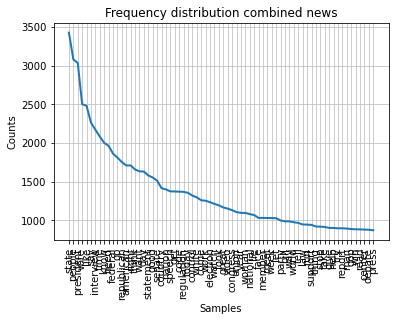

<AxesSubplot:title={'center':'Frequency distribution combined news'}, xlabel='Samples', ylabel='Counts'>

In [300]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(counts_combined)
fdist_filtered.plot(70,title='Frequency distribution combined news')

In [301]:
def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_values = []
    model_list = []
    for num_topics in notebook.tqdm(range(start, limit, step)):
        model = LdaMulticore( corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 0.01, iterations = 1000)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [302]:
# model_list, coherence_values = compute_coherence_values(texts=tokenized_texts, start=1, step=1, limit= 40, topn=5)

In [303]:
all_scores = []
for n in range(5, 10, 5):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts, start=1, step=1, limit=40, topn=n)
    all_scores.append(coherence_values)

  0%|          | 0/39 [00:00<?, ?it/s]

In [304]:
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)
print(avg_scores)

[0.09245853 0.15024291 0.18423718 0.23646969 0.23209299 0.30310515
 0.27125018 0.36396126 0.38060847 0.33515366 0.38797333 0.32897472
 0.33211692 0.36336356 0.38642653 0.41234487 0.41038521 0.39274113
 0.36042495 0.40969894 0.37624536 0.40025245 0.41232676 0.39879141
 0.40660264 0.38351249 0.41843017 0.38946288 0.41856569 0.41859561
 0.39907328 0.43083369 0.43338298 0.40908971 0.40724519 0.43288862
 0.38722776 0.42080137 0.42099092]


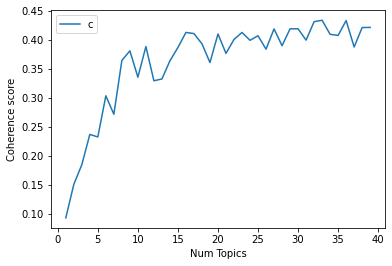

In [305]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, avg_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [306]:
def topic_modelling_results(tokenized_text, n_topics, n_iterations):
    results = []

    dictionary = Dictionary(tokenized_text) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMulticore(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS)
    
    for topic in range(N_TOPICS):
        words = lda.show_topic(topic)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_DF = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_DF, lda, dictionary, corpus

In [308]:
topics, lda_combined, dictionary, corpus = topic_modelling_results(tokenized_texts, 16, n_iterations = 1000)
topics

,Topic,Words
0,0,state people time like woman vote speech federal union try
1,1,people vote like need state know want senate interview man
2,2,lie american like president interview state vote come white know
3,3,federal think regulation code president interview time day need today
4,4,state get statement vote like say republican watch national russia
5,5,day good president help need today vote face win know
6,6,vote people want state say know bill need american party
7,7,like federal people interview regulation code president state think go
8,8,president good people need come work say go want right
9,9,president people state know think country republican say party russian


In [309]:
transformed_docs = lda_combined.get_document_topics(corpus)

In [310]:
document_topic_scores = {}
for i, document in enumerate(transformed_docs):
    max_score = 0
    # print('Topic distributions for document {}'.format(i))
    for topic in document:
        if topic[1] > max_score:
            max_score = topic[1]
        document_topic_scores[i] = {'topic':topic[0], 'score': topic[1], 'text': text_list[i]}
        # print('Topic', topic[0], 'has the highest score of', topic[1], 'for document:')
        # print(text_list[i])

In [311]:
document_topic_df = pd.DataFrame(document_topic_scores)

In [312]:
document_topic_df

,0,1,2,3,4,5,6,7,8,9,...,36934,36935,36936,36937,36938,36939,36940,36941,36942,36943
topic,6,13,3,9,0,9,11,1,1,1,...,13,10,11,10,2,15,14,13,9,15
score,0.882704,0.373767,0.33632,0.697816,0.932984,0.747653,0.932983,0.882712,0.895681,0.914684,...,0.662812,0.436884,0.392465,0.667401,0.921848,0.216022,0.2873,0.096962,0.224591,0.539069
text,a movement to dismantle america for the benefit of socialists aligned with russia yep wake up america,a satire website wrote an article about malia being expelled from harvard for smoking weed after fake,about ua contract of carriage code of federal regulations easy to research for accurate reporting rod,absolutely yes but he is also lowering his pants to an outraged threatening tweet by duke on saturday,admin votes against un plan condemning death penalty for gays with saudi arabia iraq friendly atheist,allowing rape victims to have abortions will lead to women trying to get raped we are vexed by morons,almost makes me wanna vote rt miley cyrus vows to leave the us if fking nightmare donald gets elected,american leadership will wake up to the threat when america gets itself leader again do svidnija nato,americantaliban is at it againjohn hagee calls for prosecuting women who gods name during intercourse,amnesty for all the cupcakes texas agricultural commissioner sid miller granted amnesty to cupcakes a,...,senjohnmccain think if you ran with palin again the interviews would be much more similar nowadays seriously what was that,not enough is said about the role manners play in society social media has taught us that free speech gives us control over what we but it is unfocused when people express themselves bound by rules and conventions it gives them true creative control,hotrodz83 sayance1 mrjbeetle kimbrachet auschwitzmuseum its does because that kid knows what hes doing and youre gaslighting about itjust like woman behind kavanaugh and the altright nazis in the briefing room and the white house internsthey all know what it means,facethenation speakerryan doesnt speakerryan allow stevekingia caucus as republicanall for his partys own personal power,amgela38883764 cbsnews facethenation google and read what the southern law proverty center has to almost hate group in the usa most of it growth was under,as its illegal to accept anything of value from foreign national as part of campaign negotiate us policy if one hasnt been elected or aidabet crimes committed against america by other nations there was no reason for to be in contact with these four nations,leecamp whoa whoa whoa hold the phone im pretty sure we lived in utopian province until came into office think youve lost it mr camp,there is famous debate between ken ham answers in genesis coe and bill nye famous scientistat the end of the debate the moderator asked both peoplewhat if anything will change your mindken ham nothing bill nye,we are so thrilled to host three of the founders of march for our lives tomorrow evening in their book glimmer of hope they tell their story in their own words onehundred percent of net proceeds from the book will be paid to,harlem housing developer cut off from in nyc contracts the founder and board chairman of the group and
